In [40]:
import pandas as pd
covid19World = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [41]:
covid19SG = covid19World.loc[covid19World['location']=='Singapore']
covid19SG = covid19SG.loc[covid19SG['total_cases']>0]
covid19DailyCase = covid19SG.loc[:,['date','total_cases','new_cases']]

In [42]:
covid19SG = covid19SG.reset_index(drop=True)
covid19SG.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,4.000000,0.0,4.000000,0.0
mean,2179.170000,171.010000,3.250000,0.160000,372.485900,29.230810,0.55554,0.027360,72449.000000,NaN,12.383750,NaN
std,4261.084898,336.097013,4.744747,0.443129,728.347843,57.449052,0.81098,0.075775,23408.223185,NaN,4.001066,NaN
min,3.000000,0.000000,0.000000,0.000000,0.513000,0.000000,0.00000,0.000000,47486.000000,NaN,8.117000,NaN
25%,76.500000,2.750000,0.000000,0.000000,13.076500,0.470250,0.00000,0.000000,56674.250000,NaN,9.687500,NaN
50%,193.500000,10.000000,0.000000,0.000000,33.075000,1.709000,0.00000,0.000000,71190.500000,NaN,12.168500,NaN
75%,1401.500000,109.500000,6.000000,0.000000,239.558750,18.717250,1.02600,0.000000,86965.250000,NaN,14.864750,NaN
max,17101.000000,1515.000000,16.000000,2.000000,2923.076000,258.959000,2.73500,0.342000,99929.000000,NaN,17.081000,NaN


In [43]:
covid19DailyCase['new_cases']= covid19DailyCase['new_cases'].astype(int)
covid19DailyCase['total_cases']= covid19DailyCase['total_cases'].astype(int)

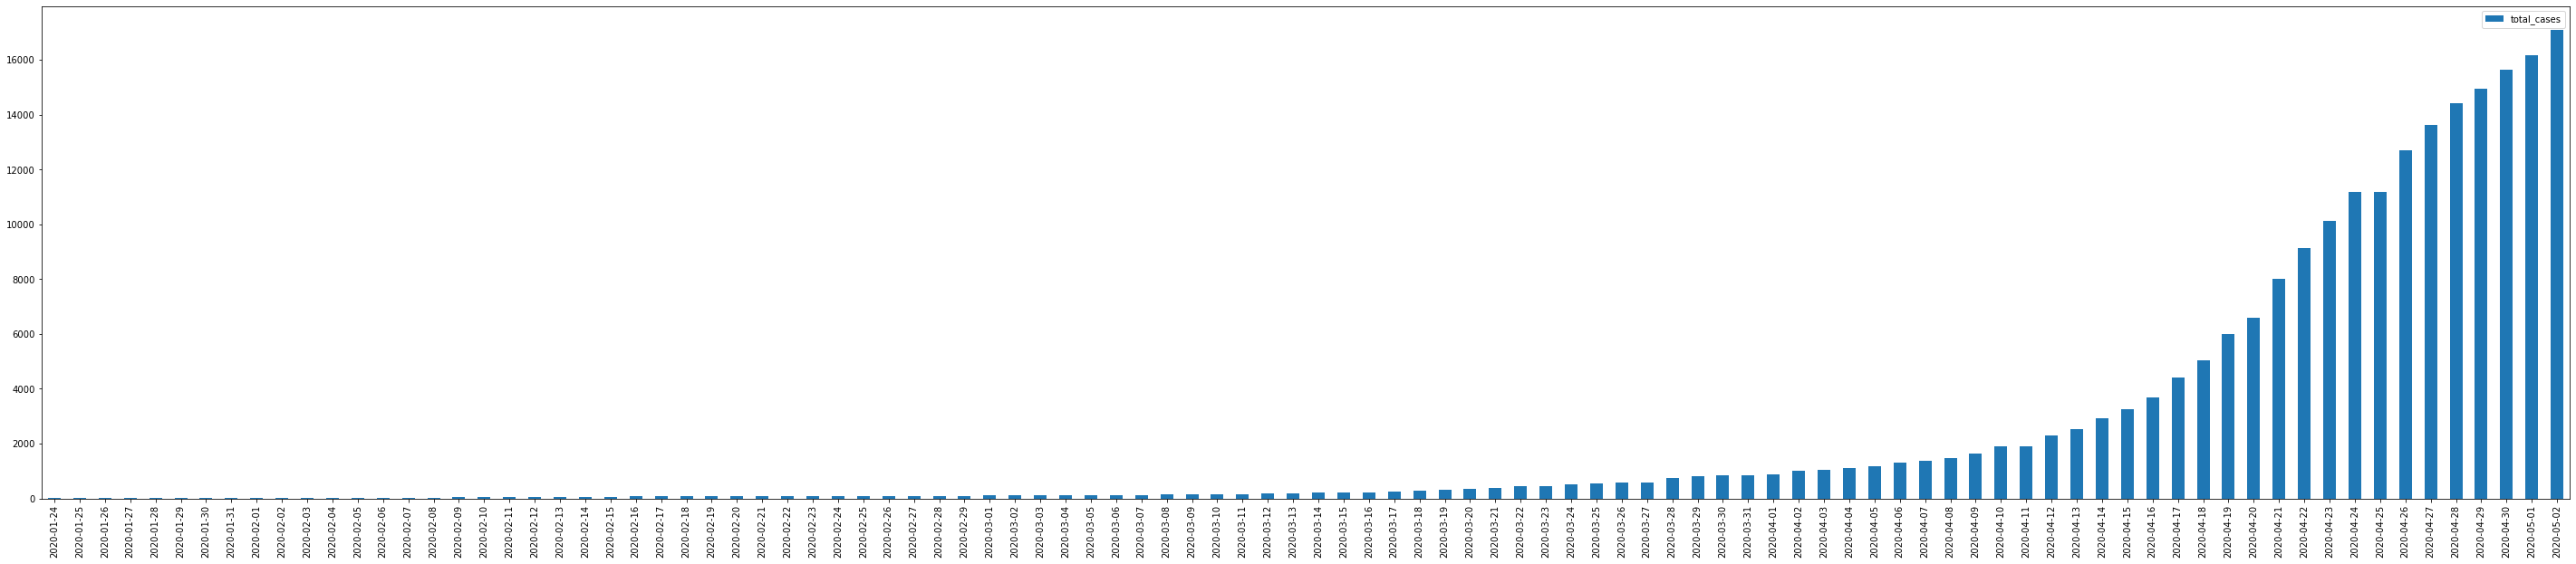

In [44]:
ax = covid19SG[['total_cases','date']].plot(kind='bar', figsize=(50,10))
ax.set_xticklabels(covid19SG['date']);

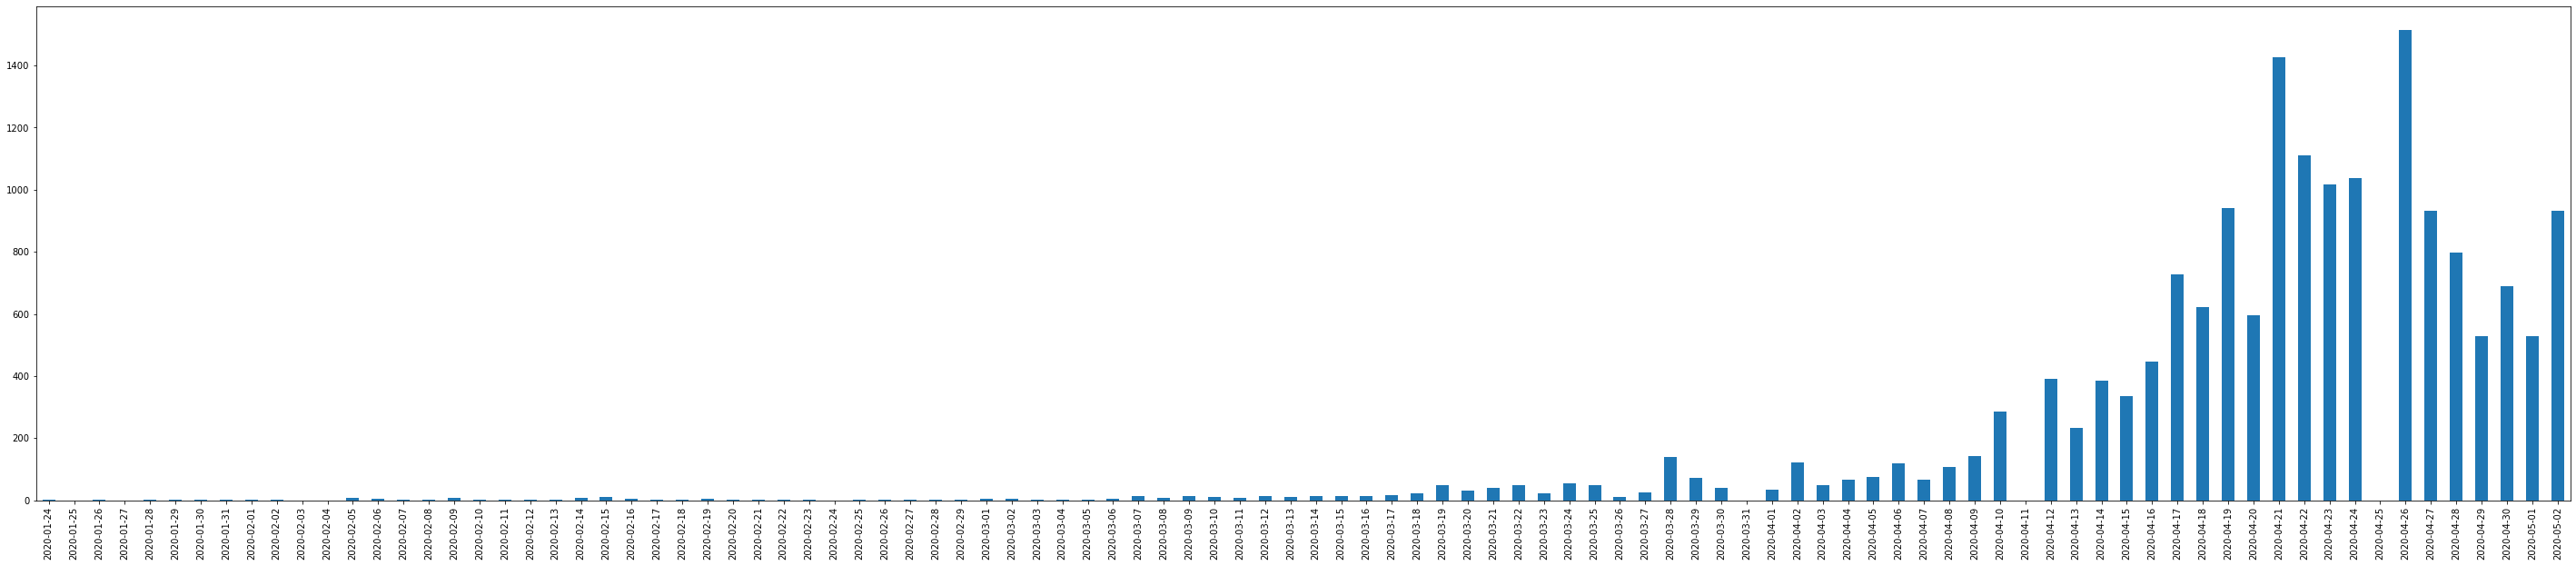

In [45]:
ax = covid19DailyCase['new_cases'].plot(kind='bar', figsize=(50,10))
ax.set_xticklabels(covid19SG['date']);

In [46]:
## We applied Population Growth Model
#  yi=β1/(1+exp(β2+β3xi))+ϵi
#  https://online.stat.psu.edu/stat501/lesson/15/15.8

In [47]:
## Display Normal Logistic Function
#from scipy.stats import logistic
#dataLength = pd.Series(range(-750,750))/100
#logisticData = pd.DataFrame(logistic.pdf(dataLength))
#ligisticAs = logisticData.plot(kind='line', figsize=(10,5))
#logisticDataCumulative = pd.DataFrame(logistic.cdf(dataLength), index=dataLength)
#ligisticAs = logisticDataCumulative.plot(kind='line', figsize=(10,5))

In [48]:
#  From the graph, we noticed the peak increase at 22/April and 26/April
#  Assume the peak growth is at 24/April (halfway point)
beta1 = 2 * covid19SG[covid19SG['date'] == '2020-04-22'].total_cases
beta1.values

array([18250])

In [49]:
# Solving initial condition
# We use 24/Jan and 06/Apr value 
import numpy as np

#np.array([[1, covid19SG[covid19SG['date'] == '2020-01-24'].index], [1, covid19SG[covid19SG['date'] == '2020-04-06'].index]])
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-01-24'].total_cases - 1))
#np.log(beta1.values/(covid19SG[covid19SG['date'] == '2020-04-06'].total_cases - 1))
A = np.array([[1, 0], [1, 73]])
y = np.array([9.118773,2.635666])
beta2, beta3 = np.linalg.solve(A,y)
beta2, beta3

(9.118773, -0.08880968493150683)

In [50]:
y = beta1.values / (1 + np.exp(beta2 + beta3 * covid19SG.index.values))
beta1.values.astype(int), beta2, beta3

(array([18250]), 9.118773, -0.08880968493150683)

In [51]:
## To continue using Non-linear Least Squared Method
# https://en.wikipedia.org/wiki/Non-linear_least_squares

In [52]:
## Instead we use python library for curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [53]:
def populationGrowthModel(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 + b3 * x))

In [54]:
xdata = covid19SG.index.values
ydata = covid19DailyCase['total_cases'].values

In [55]:
popt, pcov = curve_fit(populationGrowthModel, xdata, ydata, p0=[beta1.iloc[0], beta2, beta3])
popt, pcov

(array([ 2.23310394e+04,  1.52372562e+01, -1.66207342e-01]),
 array([[ 5.15132501e+05, -2.32138333e+02,  3.11295085e+00],
        [-2.32138333e+02,  1.46548128e-01, -1.86630690e-03],
        [ 3.11295085e+00, -1.86630690e-03,  2.39537390e-05]]))

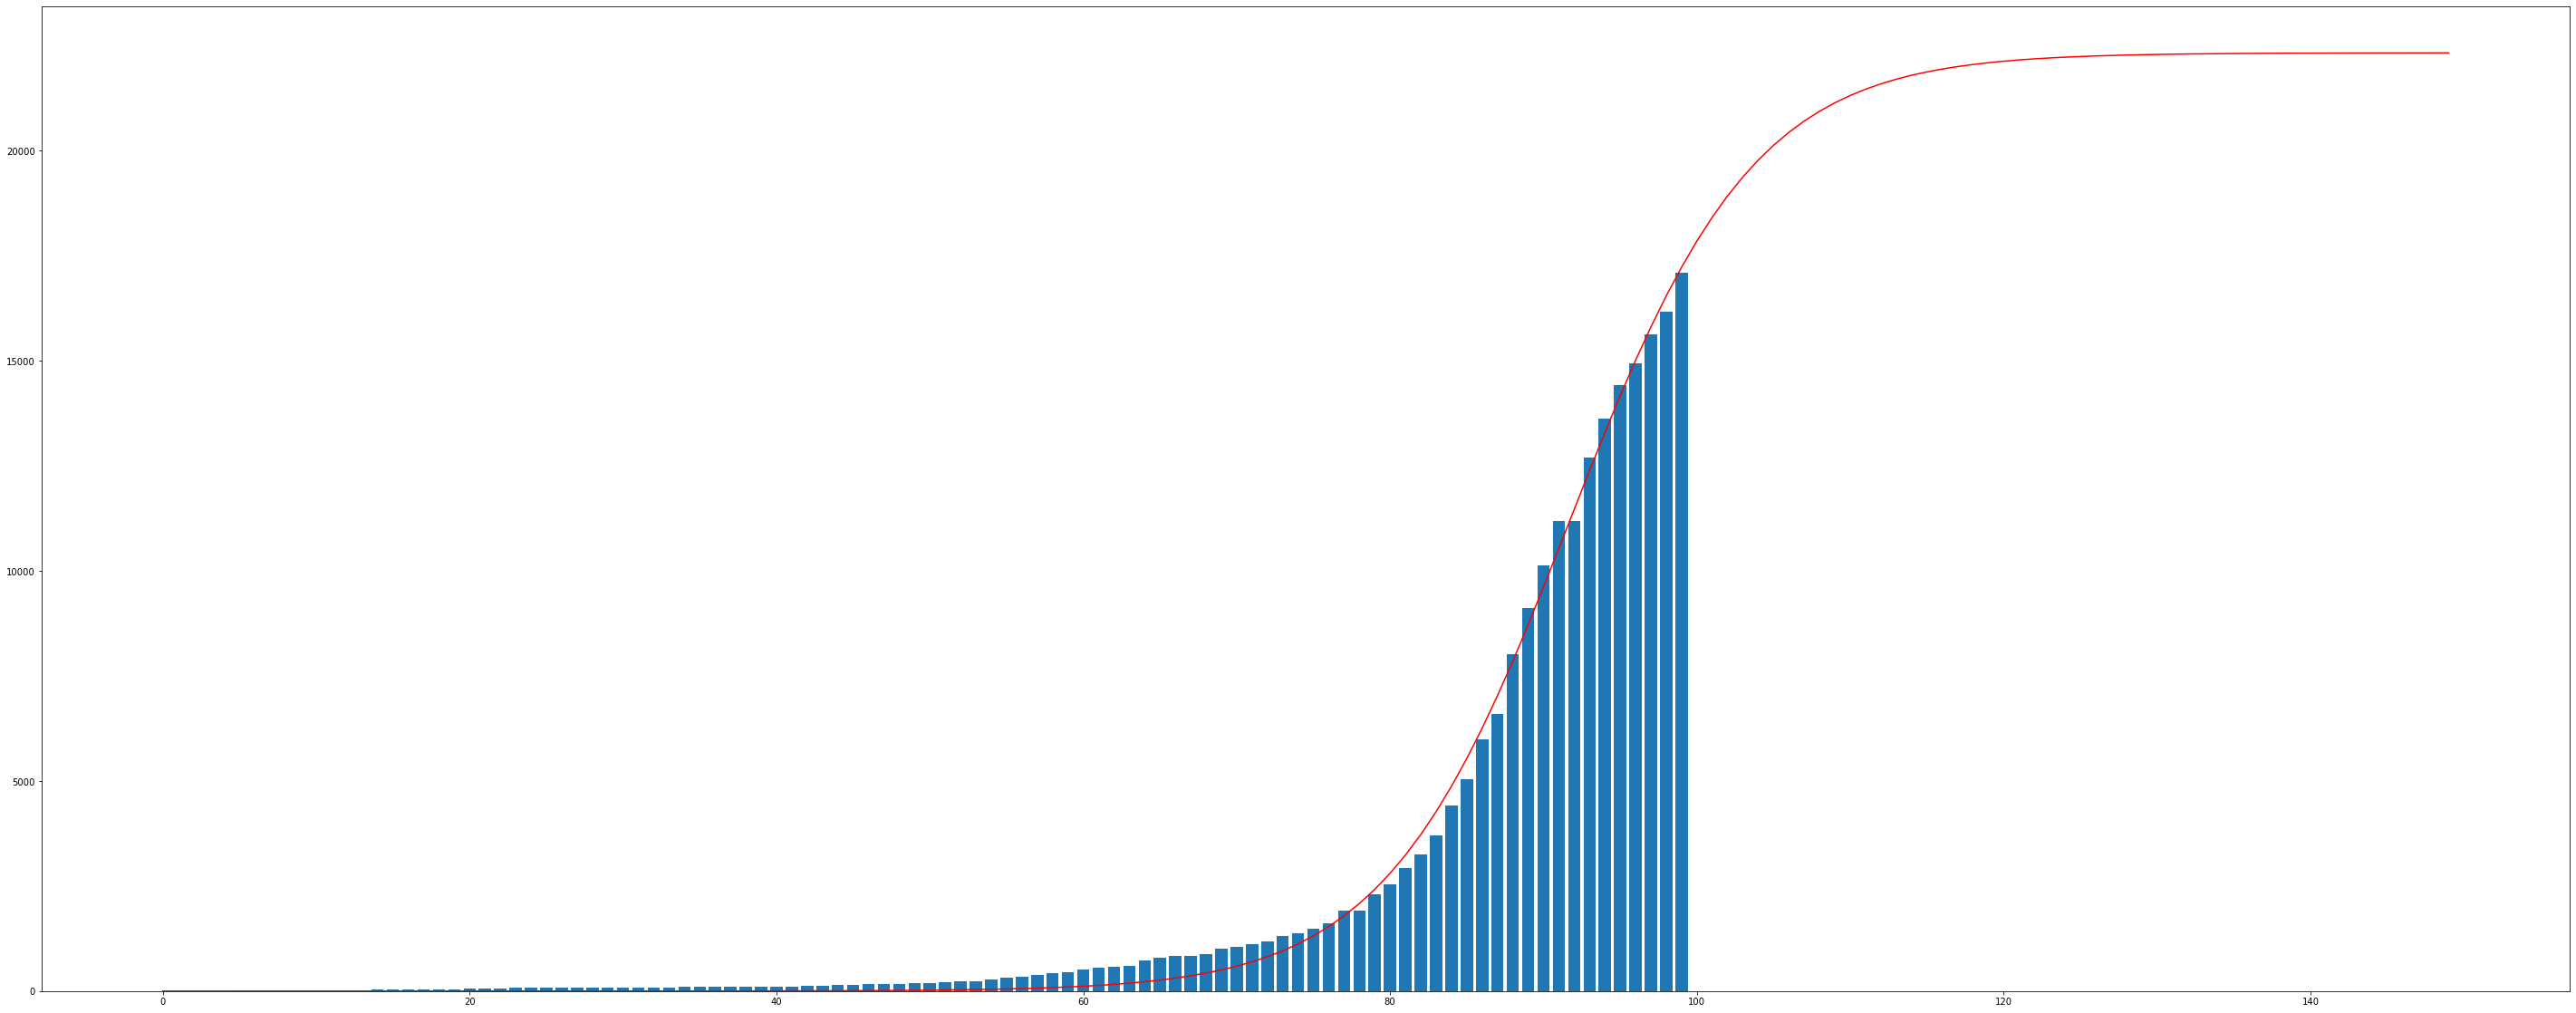

In [56]:
plt.figure(figsize=(50,20))
plt.plot(range(0,150), populationGrowthModel(range(0,150), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.bar(range(0,150), np.pad(covid19SG['total_cases'].values, (0, 50), 'constant'))
plt.show()